## DS4DS Final Task:

Upload your solution (training pipeline and final model ready for inference) as one archive file (.zip) to moodle at least three days prior to your exam appointments. Request an appointment at least two weeks in advance via email (oliver.wallscheid@uni-siegen.de). The latest exam date will be by end of September 2025. 

In [1]:
using Pkg
Pkg.activate(".")
Pkg.status()

  Activating project at `d:\ds4dsproject\final_task_data_and_aux_files\final_task`


Status `D:\ds4dsproject\final_task_data_and_aux_files\final_task\Project.toml` (empty project)


In [2]:
# this might take a few minutes, but you should only need to do this once
# when you use the project for the first time
Pkg.precompile()

In [3]:
using MAT
using Plots 
using LaTeXStrings
using Serialization
using StatsBase
using Flux

include("utils.jl");

### Thermal modelling of an electric vehicle motor

Your task is to create a model for the thermal dynamics of an electric motor.
More formally, you need to find a parameterized model of the form

$$
\begin{align}
    \frac{\mathrm{d}}{\mathrm{d}t} \mathbf{x}(t) &= \mathcal{M}_\mathbf{w} (\mathbf{x}(t), \mathbf{u}(t)) \\
    \mathbf{y}(t) & = \mathbf{x} (t)
\end{align}
$$

where $\mathbf{x}(t)$ the state of the system and $\mathbf{u(t)}$ is the input vector. The state and
input signals are described further into this notebook. There are no boundaries on the specific model class and topology regarding $\mathcal{M}_\mathbf{w}$, that is, you are allowed to investigate freely which modelling approaches are suitable.

You will be given a dataset which you can use to train/fit your model. After submission, we will evaluate your model
on a different portion of the dataset to see its generalization performance.
This evaluation will be done by comparing state trajectories predicted by your model $\hat{\mathbf{X}}_i$ with the
true trajectory $\mathbf{X}_i$ using the mean squared error (MSE). The estimate $\hat{\mathbf{X}}_i$ is to be calculated 
based on an initial true state $\mathbf{x}_{0,i}$ (which is the first element of $\mathbf{X}_i$) and the true inputs 
$\mathbf{U}_i$ (or an interpolation of the true inputs). This means that your task is to build a simulation model that produces the state trajectory based on the
initial state and inputs.

**Considered grading criteria:**

- functional and tidy codebase
- successful inference on test set (no errors)
- model and feature innovations/concepts (beyond bare-bone black-box models)
- final presentation of proposed solution and used modeling rationale
- model accuracy (MSE) on unseen/hidden test data (not part of this folder)

### Load data:

In [4]:
data = matread("train_data.mat")

Dict{String, Any} with 6 entries:
  "XNames"             => Any["TpStatTc" "TpRotTc"]
  "U"                  => [500.01 0.38556 … 59.46 61.18; 500.02 0.392385 … 59.4…
  "X"                  => [65.402 67.427; 65.3795 67.4218; … ; 81.6888 86.2227;…
  "measurement_series" => [1; 1; … ; 10; 10;;]
  "dt"                 => 0.5
  "UNames"             => Any["NSft" "TqSftClcdInv" … "TpOilRotRetA" "TpOilRotR…

In [5]:
# extract data from dict

U = data["U"];
X = data["X"];
Y = X;

UNames = data["UNames"];
XNames = data["XNames"];
YNames = XNames;

measurement_series = data["measurement_series"];
dt = data["dt"];

### Data description:

You are given a part of a dataset measured from an electric motor at Mercedes-Benz to examine its thermal properties. The dataset you are given consists of $594885$ measurement points, which are divided into $10$ independent series of measurement sessions. A short description of the different variables in the data is given in the following:

---

- ```data["U"]``` contains a matrix with the shape $594885 \times 21$. These are the $594885$ samples of the input vector $\mathbf{u}(t) \in \mathbb{R}^{21}$ which can influence its thermal behavior. In detail these are
    - $u_1$: rpm, rotations per minute of the motor shaft
    - $u_2$: torque of the drive shaft
    - $u_3$: absolute value of the torque of the drive shaft
    - $u_4$: $i_d$ d-current
    - $u_5$: $i_q$ q-current
    - $u_6$: $\| i_q \|$
    - $u_7$: root-mean-squared phase current
    - $u_8$: $u_d$ d-voltage
    - $u_{9}$: $\| u_d \|$ 
    - $u_{10}$: $u_q$ q-voltage
    - $u_{11}$: neutral point displacement voltage
    - $u_{12}$: inverter switching frequency
    - $u_{13}$: DC link voltage
    - $u_{14}$: modulation index
    - $u_{15}$: power of the drive shaft
    - $u_{16}$: oil flow rate for cooling of the rotor
    - $u_{17}$: oil flow rate for cooling of the stator
    - $u_{18}$: oil temperature at entry (rotor)
    - $u_{19}$: oil temperature at entry (stator)
    - $u_{20}$: oil temperature at exit A (rotor)
    - $u_{21}$: oil temperature at exit B (rotor)
- ```data["UNames"]``` contains abbreviations for the different elements in $\mathbf{u}(t)$, e.g. for plot labels
- ```data["X"]``` contains the state of the motor, which in this case is a stator and a rotor temperature. There are $594885$ samples of the state vector (target) $\mathbf{x}(t) \in \mathbb{R}^{2}$.
    - $x_1$: $T_{stat}$ stator temperature
    - $x_2$: $T_{rot}$ rotor temperature
- ```data["XNames"]``` contains abbreviations for the different elements in $\mathbf{x}(t)$, e.g. for plot labels
- ```data["dt"]``` contains the time between measurement points
- ```data["measurement_series"]``` contains a matrix with the shape $594885 \times 1$. That assigns each measurement point to a measurement series, i.e. the $242856$-th element in this matrix is a $4$ which means that the $242856$-th measurement belongs to measurement series $4$.

**Hint 1:** What implication does the split into multiple measurement series have? Does it make sense to use all of the data at once?

**Hint 2:** While you might not have access to the actual test data, is there a way to improve/test the generalization performance of your model?

**Hint 3:** Through the  ```utils.jl```-file in the task folder you are given a set of minimal helper functions which you can use to get a feeling for the data and create some plots.

In [ ]:
?plot_at_idx

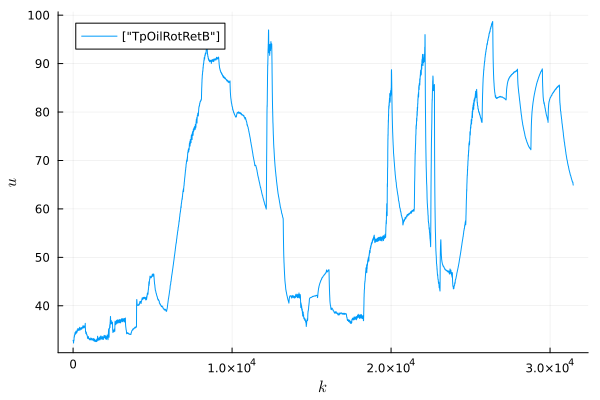

In [9]:
p1 = plot(xlabel=L"k", ylabel=L"u");
p1 = plot_at_idx(p1, U, measurement_series, UNames, measurement_series_idx=4, feature_idx=21) 

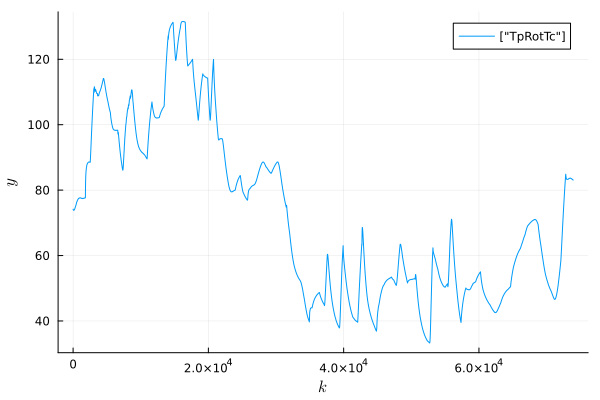

In [7]:
p2 = plot(xlabel=L"k", ylabel=L"y");
p2 = plot_at_idx(p2, Y, measurement_series, XNames, measurement_series_idx=8, feature_idx=2)

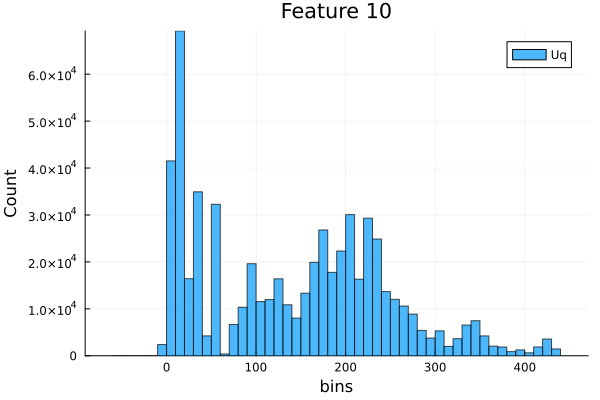

In [8]:
p = plot_histogram(U, UNames, feature_idx=10)

### Create and fit your model:

In [ ]:
# REPLACE WITH YOUR CODE
parameters = [2, 2, 5, 1]-

if @isdefined parameters
    serialize("final_task_parameters", parameters)
end
# REPLACE WITH YOUR CODE

In [29]:
#functions for feature engg and data prep
function feature_engg(u)
    return u
end

function data_prep(U_raw, X_raw, measurement_series, series_indices)
    inputs = []
    targets = []
    for series_idx in series_indices
        u_series = extract(U_raw, measurement_series, series_idx)
        x_series = extract(X_raw, measurement_series, series_idx)

        u_series = Float32.(u_series)
        x_series = Float32.(x_series)

        engineered_u = feature_engg(u_series)

        input_data = Flux.stack(eachcol(engineered_u))
        target_data = Flux.stack(eachcol(x_series))

        push!(inputs, input_data)
        push!(targets, target_data)
    end
    return inputs, targets
end

data_prep (generic function with 1 method)

In [30]:
# This function calculates the maximum features across all data sets
function find_max_features(all_inputs, all_targets)
    max_input = 0
    for inputs in all_inputs
        max_input = max(max_input, maximum(size(i, 1) for i in inputs))
    end
    max_target = 0
    for targets in all_targets
        max_target = max(max_target, maximum(size(t, 1) for t in targets))
    end
    return max_input, max_target
end

# This function pads a single data set to the given max features
function pad_to_fixed_features(inputs, targets, max_input_features, max_target_features)
    padded_inputs = []
    padded_targets = []

    for (inp, tgt) in zip(inputs, targets)
        # Pad inputs with zeros
        if size(inp, 1) < max_input_features
            padding = zeros(Float32, max_input_features - size(inp, 1), size(inp, 2))
            padded_inp = vcat(inp, padding)
        else
            padded_inp = inp
        end

        # Pad targets with zeros
        if size(tgt, 1) < max_target_features
            padding = zeros(Float32, max_target_features - size(tgt, 1), size(tgt, 2))
            padded_tgt = vcat(tgt, padding)
        else
            padded_tgt = tgt
        end

        push!(padded_inputs, padded_inp)
        push!(padded_targets, padded_tgt)
    end
    return padded_inputs, padded_targets
end

# 1. First, get all data
training_inputs, training_targets = data_prep(U, X, measurement_series, training_series_indices)
val_inputs, val_targets = data_prep(U, X, measurement_series, val_series_indices)
test_inputs, test_targets = data_prep(U, X, measurement_series, test_series_indices)

# 2. Find the global max features across all data sets
max_input_features, max_target_features = find_max_features(
    [training_inputs, val_inputs, test_inputs],
    [training_targets, val_targets, test_targets]
)

# 3. Pad all data sets using the global max features
training_inputs, training_targets = pad_to_fixed_features(training_inputs, training_targets, max_input_features, max_target_features)
val_inputs, val_targets = pad_to_fixed_features(val_inputs, val_targets, max_input_features, max_target_features)
test_inputs, test_targets = pad_to_fixed_features(test_inputs, test_targets, max_input_features, max_target_features)

(Any[Float32[499.98 0.38744998 … 74.67 75.76; 500.01 0.38839498 … 74.67 75.76; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], Float32[499.92 0.38913 … 55.24 55.08; 500.1 0.39753 … 55.19 55.05; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]], Any[Float32[77.68367 83.07999; 77.67987 83.08416; … ; 0.0 0.0; 0.0 0.0], Float32[69.90183 85.22991; 69.90491 85.18944; … ; 0.0 0.0; 0.0 0.0]])

In [16]:
unique(size(x, 1) for x in training_inputs)
println("Training data shapes:")
for i in 1:length(training_inputs)
    println("Sample $i: input size = ", size(training_inputs[i]), ", target size = ", size(training_targets[i]))
end


Training data shapes:
Sample 1: input size = (79166, 21), target size = (65611, 2)
Sample 2: input size = (79166, 21), target size = (67331, 2)
Sample 3: input size = (79166, 21), target size = (79166, 2)
Sample 4: input size = (79166, 21), target size = (31455, 2)
Sample 5: input size = (79166, 21), target size = (37083, 2)
Sample 6: input size = (79166, 21), target size = (71342, 2)


In [17]:
sample_input = training_inputs[1]
sample_target = training_targets[1]

println("Sample input size: ", size(sample_input))
println("Sample target size: ", size(sample_target))

Flux.reset!(model)
output = model(sample_input[:, 1:2])  # Forward pass on first 2 timesteps

println("Model output size: ", size(output))


Sample input size: (79166, 21)
Sample target size: (65611, 2)
Model output size: (65611, 2)


In [31]:
using Flux, Flux.Optimise
using Flux: params

#model
num_input_features = size(training_inputs[1], 1)
num_output_features = size(training_targets[1], 1)

hidden_size = 64
model = Chain(
    LSTM(num_input_features => hidden_size), 
    Dense(hidden_size, num_output_features)
)

#loss
mse(predicted, target) = mean(abs2, predicted .- target)

#optimizer
optimizer = Flux.setup(ADAM(), model)

#eval
function evaluate_model(model, inputs, targets)
    total_loss = 0.0
    for (input, target) in zip(inputs, targets)
        Flux.reset!(model)

        len = min(size(input, 2), size(target, 2))

        model(reshape(input[:, 1], :, 1))
        predicted_traj = []

        for t in 2:len
            prediction = model(reshape(input[:, t], :, 1))
            push!(predicted_traj, prediction)
        end
        predicted_traj = hcat(predicted_traj...)

        prediction_targets = target[:, 2:len]
        total_loss += mse(predicted_traj, prediction_targets)
    end
    return total_loss/length(inputs)
    
end

#training
epochs = 10
for epoch in 1:epochs
    for (inputs, targets) in zip(training_inputs, training_targets)
        Flux.reset!(model)

        loss_function() = begin
            len = min(size(inputs, 2), size(targets, 2))

            model(reshape(inputs[:, 1], :, 1))

            predicted_traj = hcat([model(reshape(inputs[:, t], :, 1)) for t in 2:len]...)

           #  predicted_traj = []
           #  for t in 2:size(inputs,2)
           #     prediction = model(reshape(inputs[:, t], :, 1))
           #     push!(predicted_traj,prediction)
           # end
           # predicted_traj = hcat(predicted_traj...)
            prediction_targets = targets[:, 2:len]
            mse(predicted_traj, prediction_targets)
        end
        
        loss, back = Flux.pullback(model -> loss_function(), model)
        grads = back(1f0)
        optimizer, model = Optimisers.update(optimizer, model, grads[1])
    end

    train_loss = evaluate_model(model, training_inputs, training_targets)
    validation_loss = evaluate_model(model, val_inputs, val_targets)
    
    println("Epoch $epoch, Training Loss: $train_loss, Validation Loss: $validation_loss")
end

Epoch 1, Training Loss: 5331.986897786458, Validation Loss: 6156.166015625
Epoch 2, Training Loss: 5331.986897786458, Validation Loss: 6156.166015625
Epoch 3, Training Loss: 5331.986897786458, Validation Loss: 6156.166015625
Epoch 4, Training Loss: 5331.986897786458, Validation Loss: 6156.166015625
Epoch 5, Training Loss: 5331.986897786458, Validation Loss: 6156.166015625
Epoch 6, Training Loss: 5331.986897786458, Validation Loss: 6156.166015625
Epoch 7, Training Loss: 5331.986897786458, Validation Loss: 6156.166015625
Epoch 8, Training Loss: 5331.986897786458, Validation Loss: 6156.166015625
Epoch 9, Training Loss: 5331.986897786458, Validation Loss: 6156.166015625
Epoch 10, Training Loss: 5331.986897786458, Validation Loss: 6156.166015625


In [ ]:
final_model = model

test_loss = evaluate_model(final_model, test_inputs, test_targets)
println("Final test Loss: $test_loss")

serialize("final_task_parameters", params(final_model))

### Saving your model for evaluation:

After you have finished your model, we will evaluate its performance on the test dataset. To do so we will need to be able to make a forward pass with your model and we will need you to give us your model parameters.

- fill out the function given in ```model_forward_pass.jl```
- store your parameters in a file named ```final_task_parameters```

```
# Example code for storing parameters:

if @isdefined parameters
    serialize("final_task_parameters", parameters)
end
```

You can use the code below on the training to check if your result can be read properly **(If you run into problems with this or if your forward pass needs extra inputs, please contact us)**:

In [ ]:
include("model_forward_pass.jl");
using .ModelForwardPass

In [ ]:
?ModelForwardPass.your_model_forward_pass

In [ ]:
parameters_evaluation = deserialize("final_task_parameters");

measurement_series_idx = 1

_u = extract(U, measurement_series, measurement_series_idx);
_target = extract(X, measurement_series, measurement_series_idx);
_x0 = _target[1, :];

tsteps = collect(0:0.5:(size(_u, 1) * 0.5));

predicted_trajectory = ModelForwardPass.your_model_forward_pass(
    inputs=_u,
    x0=_x0,
    parameters=parameters_evaluation,
    tsteps=tsteps
);

println("MSE: ", StatsBase.mean((_target - predicted_trajectory).^2))

p_eval = plot(xlabel=L"k", ylabel=L"x")

p_eval = plot_at_idx(p_eval, X, measurement_series, XNames, measurement_series_idx=measurement_series_idx, feature_idx=1)
p_eval = plot!(p_eval, predicted_trajectory[:, 1], label=L"\hat{x}_1")

display(p_eval)

p_eval = plot(xlabel=L"k", ylabel=L"x")

p_eval = plot_at_idx(p_eval, X, measurement_series, XNames, measurement_series_idx=measurement_series_idx, feature_idx=2)
p_eval = plot!(p_eval, predicted_trajectory[:, 2], label=L"\hat{x}_2")

display(p_eval)